In [13]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

class TONDataset(Dataset):
    def __init__(self, data_root, label_root):
        sc = MinMaxScaler()
        samples = pd.read_csv(data_root)
        self.samples = pd.DataFrame(sc.fit_transform(samples))
        self.labels = pd.read_csv(label_root)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels.iloc[idx]).float().requires_grad_()
        sample = torch.tensor(self.samples.iloc[idx]).float().requires_grad_()
        return sample, label

In [14]:
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

BATCH_SIZE = 1024
TEST_SPLIT_SIZE = .2
SHUFFLE = True
RANDOM_SEED = 42

PATH = "/root/code/iot_ddos_detection/data/"
data_filename = "preprocess.csv"
label_filename = "label_data.csv"

dataset = TONDataset(PATH + data_filename, PATH + label_filename)

# Train and Test split
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT_SIZE * dataset_size))
if SHUFFLE:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Sampler
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Data Loader
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [26]:
import torch.nn as nn

torch.manual_seed(1)
HIDDEN_SIZE = 64

class CONV1D(nn.Module):
    def __init__(self):
        super(CONV1D, self).__init__()

        self.conv1d1 = nn.Conv1d(in_channels=1, out_channels=HIDDEN_SIZE, kernel_size=3, stride=2)
        self.dropout1 = nn.Dropout(0.5)

        self.conv1d2 = nn.Conv1d(in_channels=HIDDEN_SIZE, out_channels=HIDDEN_SIZE, kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(HIDDEN_SIZE * 8, 1)

    def forward(self, x):
        output = self.conv1d1(x)
        output = self.dropout1(output)

        output = self.conv1d2(output)
        output = self.dropout2(output)

        output = output.view(-1,HIDDEN_SIZE*8)

        output = self.fc3(output)
        output = torch.sigmoid(output)

        return output

model = CONV1D()

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(device)
    model.to(device)

cuda:0


In [28]:
LEARNING_RATE = 0.001
EPOCHS = 30

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
import copy
import time

start_time = time.time()

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for i in range(EPOCHS):
    num_correct = 0
    num_samples = 0
    train_loss = 0.0
    for j, data in enumerate(train_dataloader):

        x = data[:][0].view(-1,1,36)
        y = data[:][1]

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        train_output = model(x)

        loss = criterion(train_output.float(), y.float())
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        y_pred = np.round(train_output.cpu().detach()).tolist()
        y = y.cpu().detach().tolist()

        num_correct += sum(1 for a,b in zip(y_pred,y) if a == b)
        num_samples += len(y_pred)
        accuracy = (float(num_correct) / float(num_samples)) * 100

    train_loss_history.append(train_loss/len(train_dataloader))
    train_accuracy_history.append(accuracy)

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        test_loss = 0.0

        for test_index, test_data in enumerate(test_dataloader):
            test_x = test_data[:][0].view(-1,1,36).to(device)
            test_y = test_data[:][1].to(device)

            test_output = model(test_x)

            loss = criterion(test_output.float(), test_y)

            test_loss += loss.item()

            y_pred = np.round(test_output.cpu().detach()).tolist()
            y = test_y.cpu().detach().tolist()

            num_correct += sum(1 for a,b in zip(y_pred,y) if a == b)
            num_samples += len(y_pred)
            accuracy = (float(num_correct) / float(num_samples)) * 100

    test_loss_history.append(test_loss/len(test_dataloader))
    test_accuracy_history.append(accuracy)

    print(f"Epoch %d/%d, Training Loss: %.3f, Test loss: %.3f, Accuracy: %.2f" %(i+1, EPOCHS,train_loss/len(train_dataloader), (test_loss/len(test_dataloader)), accuracy))

end_time = time.time()

print(f"Train Duration: {end_time - start_time}")

best_model_weights = copy.deepcopy(model.state_dict())
torch.save(model.state_dict(),f"small_conv1d_{HIDDEN_SIZE}_{LEARNING_RATE}_{EPOCHS}.pth")

Epoch 1/30, Training Loss: 0.510, Test loss: 0.475, Accuracy: 79.97
Epoch 2/30, Training Loss: 0.463, Test loss: 0.460, Accuracy: 81.21
Epoch 3/30, Training Loss: 0.455, Test loss: 0.458, Accuracy: 82.17
Epoch 4/30, Training Loss: 0.451, Test loss: 0.453, Accuracy: 82.99
Epoch 5/30, Training Loss: 0.446, Test loss: 0.445, Accuracy: 83.07
Epoch 6/30, Training Loss: 0.443, Test loss: 0.446, Accuracy: 83.71
Epoch 7/30, Training Loss: 0.441, Test loss: 0.444, Accuracy: 82.14
Epoch 8/30, Training Loss: 0.439, Test loss: 0.443, Accuracy: 84.17
Epoch 9/30, Training Loss: 0.438, Test loss: 0.440, Accuracy: 84.23
Epoch 10/30, Training Loss: 0.437, Test loss: 0.443, Accuracy: 81.16
Epoch 11/30, Training Loss: 0.436, Test loss: 0.437, Accuracy: 84.35
Epoch 12/30, Training Loss: 0.435, Test loss: 0.439, Accuracy: 83.48
Epoch 13/30, Training Loss: 0.435, Test loss: 0.437, Accuracy: 83.21
Epoch 14/30, Training Loss: 0.434, Test loss: 0.440, Accuracy: 83.47
Epoch 15/30, Training Loss: 0.433, Test los

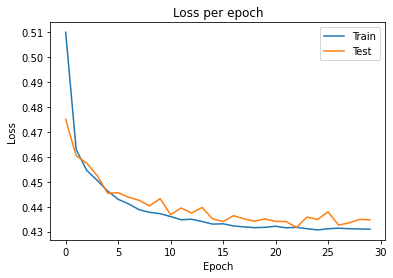

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Train')
plt.plot(test_loss_history, label='Test')
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

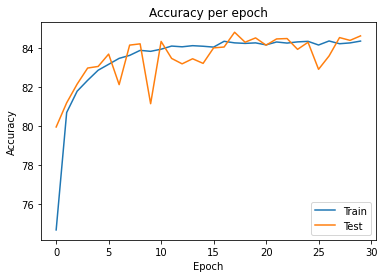

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_history, label='Train')
plt.plot(test_accuracy_history, label='Test')
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
results = pd.DataFrame({
    "train_loss": train_loss_history,
    "test_loss": test_loss_history,
    "train_acc": train_accuracy_history,
    "test_acc": test_accuracy_history,
})
results.to_csv(f'result_small_rnn_{HIDDEN_SIZE}_{LEARNING_RATE}_{EPOCHS}.csv', index=False)